**TASK - 1**

a. Imported All the neccessary libraries.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

**TASK - 1**
1. Load Data: Load the Breast Cancer Wisconsin dataset directly from scikit-learn.
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data
y = data.target
2. Inspect Data: Print the shapes of X and y and the feature names to understand the data.
This is a binary classification problem.
3. Create Hold-Out Set: Perform a single 70/30 split on the data.
X_train , y_train (70% of the data)
X_val , y_val (30% of the data)
Use train_test_split with random_state=42 for reproducibility.
4. Standardize Features: This is critical for neural networks.
Fit a StandardScaler from sklearn.preprocessing on X_train only.

Transform both X_train and X_val using the fitted scaler.
X_train_scaled will be used for training, and X_val_scaled for all final evaluations.

In [ ]:
# 1) Load dataset
data = load_breast_cancer()
X = data.data.astype(float)         # (n_samples, n_features)
y = data.target.astype(int)         # (n_samples,)

print("X shape:", X.shape, "| y shape:", y.shape)
print("Features:", list(data.feature_names))

# 2) 70/30 split (hold-out set)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# 3) Standardize using train stats ONLY
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

print("Train/Val shapes:", X_train_scaled.shape, X_val_scaled.shape, y_train.shape, y_val.shape)

X shape: (569, 30) | y shape: (569,)
Features: [np.str_('mean radius'), np.str_('mean texture'), np.str_('mean perimeter'), np.str_('mean area'), np.str_('mean smoothness'), np.str_('mean compactness'), np.str_('mean concavity'), np.str_('mean concave points'), np.str_('mean symmetry'), np.str_('mean fractal dimension'), np.str_('radius error'), np.str_('texture error'), np.str_('perimeter error'), np.str_('area error'), np.str_('smoothness error'), np.str_('compactness error'), np.str_('concavity error'), np.str_('concave points error'), np.str_('symmetry error'), np.str_('fractal dimension error'), np.str_('worst radius'), np.str_('worst texture'), np.str_('worst perimeter'), np.str_('worst area'), np.str_('worst smoothness'), np.str_('worst compactness'), np.str_('worst concavity'), np.str_('worst concave points'), np.str_('worst symmetry'), np.str_('worst fractal dimension')]
Train/Val shapes: (398, 30) (171, 30) (398,) (171,)


**TASK - 2.**

Implement the following helper functions using only NumPy.
1. Activation Functions:
sigmoid(Z) : Computes the sigmoid.
relu(Z) : Computes the Rectified Linear Unit ( np.maximum(0, Z) ).
2. Activation Derivatives: These are crucial for backpropagation.
sigmoid_derivative(A) : Where A = sigmoid(Z) . The derivative is A * (1 - A) .
relu_derivative(Z) : The derivative is 1 if Z > 0 , and 0 otherwise.
3. Loss Functions:
compute_bce_loss(Y, Y_hat) : Computes the Binary Cross-Entropy (BCE) loss. (Add a
small epsilon=1e-15 for numerical stability to avoid log(0) ).
compute_mse_loss(Y, Y_hat) : Computes the Mean Squared Error (MSE) loss.

In [ ]:
# --- Activations
def sigmoid(Z):
    return 1.0 / (1.0 + np.exp(-Z))

def relu(Z):
    return np.maximum(0, Z)

# --- Derivatives (Z-based forms)
def sigmoid_derivative(A):  # input is A = sigmoid(Z)
    return A * (1.0 - A)

def relu_derivative(Z):
    return (Z > 0).astype(float)

# --- Losses
def compute_bce_loss(Y, Y_hat, eps=1e-15):
    """
    Y, Y_hat shape: (1, m)
    """
    Y_hat = np.clip(Y_hat, eps, 1 - eps)
    m = Y.shape[1]
    loss = - (np.sum(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat))) / m
    return loss

def compute_mse_loss(Y, Y_hat):
    """
    Y, Y_hat shape: (1, m)
    """
    m = Y.shape[1]
    loss = np.sum((Y - Y_hat) ** 2) / m
    return loss

**TASK - 3.**

Implement a MyANNClassifier class. This class will orchestrate the entire learning process.
1. Class Structure ( __init__ ):
__init__(self, layer_dims, learning_rate=0.01, n_iterations=1000, loss='bce') :
layer_dims : A list specifying the number of units in each layer. e.g., [n_x, 10, 5, 1] ,
where n_x is the number of input features (30 for the breast cancer dataset).
Store learning_rate , n_iterations , and loss (either 'bce' or 'mse').
self.parameters_ : A dictionary to store weights ( W1 , W2 , ...) and biases ( b1 , b2 ,
...).
self.costs_ : A list to store the loss at each iteration (for plotting).

2. Parameter Initialization ( _initialize_parameters ):
Create a helper method that iterates through layer_dims .
Initialize weights W with small random values ( np.random.randn(...) * 0.01 ) to break
symmetry.



Initialize biases b as zeros ( np.zeros(...) ).
Store them in self.parameters_ (e.g., self.parameters_['W1'] , self.parameters_['b1'] ).

3. Forward Propagation ( _forward_propagation ):
Create a method _forward_propagation(self, X) .
A_prev = X .
Loop from layer 1 to L:
The hidden layers (1 to L-1) must use the ReLU activation.
The output layer (L) must use the Sigmoid activation (for binary
classification).
Calculate Z = W @ A_prev + b .
Calculate A = activation(Z) .
Store all A (activations) and Z (linear results) in a cache (e.g., a list of tuples
(A, Z) ). This cache is essential for backpropagation.
Return the final activation A_L (which is Y_hat ) and the cache .

4. Backward Propagation ( _backward_propagation ):
Create a method _backward_propagation(self, Y, Y_hat, cache) . This is the most complex
task.
Y is the true labels, Y_hat is the prediction ( A_L ) from the forward pass.
Initialize Backprop:
Calculate dA_L (the derivative of the loss function w.r.t. Y_hat ).
If self.loss == 'bce' : dA_L = -(np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat))
If self.loss == 'mse' : dA_L = 2 * (Y_hat - Y)
Output Layer (Sigmoid):
Get A_L and Z_L from the cache .
dZ_L = dA_L * sigmoid_derivative(A_L)
Calculate dW_L and db_L using dZ_L and the corresponding A_prev from the
cache.
Loop Backwards (Hidden Layers - ReLU):
Iterate from layer L-1 down to 1.

Calculate dA_prev = W.T @ dZ (using W and dZ from the current layer).
dZ_prev = dA_prev * relu_derivative(Z_prev) (using Z_prev from the cache).
Calculate dW and db for this layer.
Store all gradients ( dW1 , db1 , dW2 , db2 , ...) in a grads dictionary.

5. Parameter Update ( _update_parameters ):
Create a method _update_parameters(self, grads) .
Iterate through all parameters in self.parameters_ .
Update them using gradient descent:
W = W - self.learning_rate * dW
b = b - self.learning_rate * db

6. Fit and Predict Methods:
fit(self, X, y) :
Reshape y to be (1, n_samples) .
Reshape X to be (n_features, n_samples) .
Call _initialize_parameters .
Loop for n_iterations :


a. Y_hat, cache = _forward_propagation(X)

b. loss = compute_bce_loss(y, Y_hat) (or mse based on self.loss )

c. grads = _backward_propagation(y, Y_hat, cache)

d. _update_parameters(grads)

e. Store the loss in self.costs_ .
predict(self, X) :
Reshape X to (n_features, n_samples) .

Run _forward_propagation(X) to get Y_hat .
Convert probabilities to binary predictions: predictions = (Y_hat > 0.5).astype(int) .
Return the flattened 1D array of predictions.

In [ ]:
class MyANNClassifier:
    """
    Fully-connected feedforward NN for binary classification.
    Hidden layers: ReLU
    Output layer: Sigmoid
    Loss: 'bce' or 'mse'
    """
    def __init__(self, layer_dims, learning_rate=0.01, n_iterations=1000, loss='bce', seed=42, verbose=False):
        """
        layer_dims: list, e.g. [n_x, 10, 1]
        """
        self.layer_dims   = layer_dims
        self.learning_rate = float(learning_rate)
        self.n_iterations  = int(n_iterations)
        assert loss in ('bce', 'mse')
        self.loss          = loss
        self.parameters_   = {}
        self.costs_        = []
        self.verbose       = verbose
        self.rng           = np.random.default_rng(seed)

    # ---------- Parameter init ----------
    def _initialize_parameters(self):
        self.parameters_ = {}
        L = len(self.layer_dims) - 1  # number of layers with params
        for l in range(1, L + 1):
            n_l  = self.layer_dims[l]
            n_lm1 = self.layer_dims[l-1]
            # He init for ReLU layers; for last layer also fine at this scale
            W = self.rng.normal(0, np.sqrt(2.0 / n_lm1), size=(n_l, n_lm1))
            b = np.zeros((n_l, 1))
            self.parameters_[f"W{l}"] = W
            self.parameters_[f"b{l}"] = b

    # ---------- Forward ----------
    def _forward_propagation(self, X):
        """
        X shape: (n_features, m)
        Returns: Y_hat (A_L), cache (list of (A_prev, Z, activation_type))
        """
        cache = []
        A_prev = X
        L = len(self.layer_dims) - 1

        for l in range(1, L + 1):
            W = self.parameters_[f"W{l}"]
            b = self.parameters_[f"b{l}"]
            Z = W @ A_prev + b

            if l < L:  # hidden -> ReLU
                A = relu(Z)
                act = "relu"
            else:      # output -> Sigmoid
                A = sigmoid(Z)
                act = "sigmoid"

            cache.append((A_prev, Z, act))
            A_prev = A

        A_L = A_prev
        return A_L, cache

    # ---------- Backward ----------
    def _backward_propagation(self, Y, Y_hat, cache):
        """
        Y, Y_hat shape: (1, m)
        cache: list of tuples from forward
        Returns grads dict with dW{l}, db{l}
        """
        grads = {}
        m = Y.shape[1]
        L = len(cache)

        # dA of loss wrt A_L
        if self.loss == 'bce':
            eps = 1e-15
            Y_hat_clipped = np.clip(Y_hat, eps, 1 - eps)
            dA = -(np.divide(Y, Y_hat_clipped) - np.divide(1 - Y, 1 - Y_hat_clipped))
        else:  # mse
            dA = 2 * (Y_hat - Y)

        for l in reversed(range(1, L + 1)):
            A_prev, Z, act = cache[l-1]
            W = self.parameters_[f"W{l}"]

            # dZ
            if act == "sigmoid":
                A = sigmoid(Z)
                dZ = dA * sigmoid_derivative(A)
            else:  # relu
                dZ = dA * relu_derivative(Z)

            dW = (dZ @ A_prev.T) / m
            db = np.sum(dZ, axis=1, keepdims=True) / m
            grads[f"dW{l}"] = dW
            grads[f"db{l}"] = db

            # dA_prev for next step
            dA = W.T @ dZ

        return grads

    # ---------- Update ----------
    def _update_parameters(self, grads):
        L = (len(self.layer_dims) - 1)
        for l in range(1, L + 1):
            self.parameters_[f"W{l}"] -= self.learning_rate * grads[f"dW{l}"]
            self.parameters_[f"b{l}"] -= self.learning_rate * grads[f"db{l}"]

    # ---------- Fit ----------
    def fit(self, X, y):
        """
        X: (n_samples, n_features); y: (n_samples,)
        """
        # reshape to (n_features, m) / (1, m)
        X_ = X.T
        Y_ = y.reshape(1, -1)

        self._initialize_parameters()
        self.costs_.clear()

        for i in range(1, self.n_iterations + 1):
            Y_hat, cache = self._forward_propagation(X_)

            if self.loss == 'bce':
                cost = compute_bce_loss(Y_, Y_hat)
            else:
                cost = compute_mse_loss(Y_, Y_hat)
            self.costs_.append(cost)

            grads = self._backward_propagation(Y_, Y_hat, cache)
            self._update_parameters(grads)

            if self.verbose and (i % max(1, self.n_iterations // 10) == 0):
                print(f"iter {i}/{self.n_iterations} | loss: {cost:.5f}")

        return self

    # ---------- Predict ----------
    def predict_proba(self, X):
        X_ = X.T
        Y_hat, _ = self._forward_propagation(X_)
        return Y_hat.flatten()  # (m,)

    def predict(self, X):
        probs = self.predict_proba(X)
        return (probs > 0.5).astype(int)

**TASK - 4**

1. Model 1 ( BCE Loss )

a. Define your layer_dims . Start with one hidden layer (e.g., [30, 10, 1] ).

b. Instantiate MyANNClassifier with loss='bce' , learning_rate=0.001 , and n_iterations=5000 .

c. fit the model on X_train_scaled and y_train .

d. predict on X_val_scaled .

e. Print the classification_report for this model.

In [ ]:
# Model 1: BCE loss, 1 hidden layer
n_x = X_train_scaled.shape[1]
layer_dims_m1 = [n_x, 10, 1]

model_bce = MyANNClassifier(
    layer_dims=layer_dims_m1,
    learning_rate=0.001,
    n_iterations=5000,
    loss='bce',
    verbose=False,
    seed=42
).fit(X_train_scaled, y_train)

y_pred_m1 = model_bce.predict(X_val_scaled)
print("=== Model 1 (BCE) ===")
print(classification_report(y_val, y_pred_m1, digits=4))

=== Model 1 (BCE) ===
              precision    recall  f1-score   support

           0     0.9825    0.8750    0.9256        64
           1     0.9298    0.9907    0.9593       107

    accuracy                         0.9474       171
   macro avg     0.9561    0.9328    0.9424       171
weighted avg     0.9495    0.9474    0.9467       171



**TASK - 4**

2. Model - 2 ( MSE LOSS ).

In [ ]:
layer_dims_m2 = layer_dims_m1  # exact same architecture

model_mse = MyANNClassifier(
    layer_dims=layer_dims_m2,
    learning_rate=0.001,
    n_iterations=5000,
    loss='mse',
    verbose=False,
    seed=42
).fit(X_train_scaled, y_train)

y_pred_m2 = model_mse.predict(X_val_scaled)
print("=== Model 2 (MSE) ===")
print(classification_report(y_val, y_pred_m2, digits=4))

=== Model 2 (MSE) ===
              precision    recall  f1-score   support

           0     0.9649    0.8594    0.9091        64
           1     0.9211    0.9813    0.9502       107

    accuracy                         0.9357       171
   macro avg     0.9430    0.9203    0.9297       171
weighted avg     0.9375    0.9357    0.9348       171



**TASK - 4**

3. Model - 3 ( Deeper Architecture )

In [ ]:
# Deeper architecture example: [n_x, 30, 10, 5, 1]
layer_dims_m3 = [n_x, 30, 10, 5, 1]

model_deep = MyANNClassifier(
    layer_dims=layer_dims_m3,
    learning_rate=0.001,
    n_iterations=5000,
    loss='bce',
    verbose=False,
    seed=42
).fit(X_train_scaled, y_train)

y_pred_m3 = model_deep.predict(X_val_scaled)
print("=== Model 3 (BCE, deeper) ===")
print(classification_report(y_val, y_pred_m3, digits=4))

=== Model 3 (BCE, deeper) ===
              precision    recall  f1-score   support

           0     0.9677    0.9375    0.9524        64
           1     0.9633    0.9813    0.9722       107

    accuracy                         0.9649       171
   macro avg     0.9655    0.9594    0.9623       171
weighted avg     0.9650    0.9649    0.9648       171



**Task 5: Comparison with scikit-learn**

1. Train MLPClassifier :

a. Import from sklearn.neural_network import MLPClassifier .

b. Instantiate MLPClassifier with parameters that roughly match your best "from scratch"
model.

c. Example: MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='adam', max_iter=1000,
learning_rate_init=0.001, random_state=42) .

d. fit the MLPClassifier on X_train_scaled and y_train .


2. Evaluate MLPClassifier :
predict on X_val_scaled .
Print the classification_report for the sklearn model.

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(10,),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42
)
mlp.fit(X_train_scaled, y_train)

y_pred_sklearn = mlp.predict(X_val_scaled)
print("=== scikit-learn MLPClassifier ===")
print(classification_report(y_val, y_pred_sklearn, digits=4))

=== scikit-learn MLPClassifier ===
              precision    recall  f1-score   support

           0     0.9545    0.9844    0.9692        64
           1     0.9905    0.9720    0.9811       107

    accuracy                         0.9766       171
   macro avg     0.9725    0.9782    0.9752       171
weighted avg     0.9770    0.9766    0.9767       171



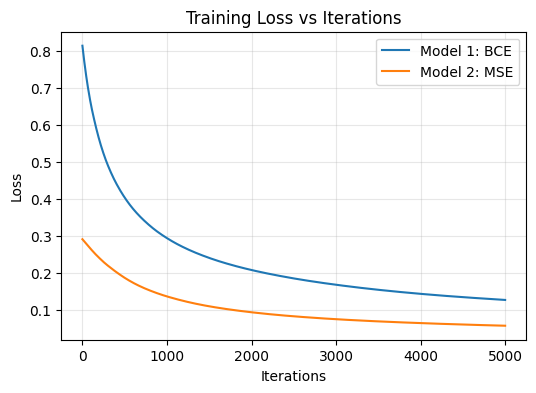

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(model_bce.costs_, label="Model 1: BCE")
plt.plot(model_mse.costs_, label="Model 2: MSE")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss vs Iterations")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

def metrics_for_positive_class(y_true, y_pred):
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    return p, r, f1

rows = []
rows.append(("MyANN (BCE, 1 hidden)",) + metrics_for_positive_class(y_val, y_pred_m1))
rows.append(("MyANN (MSE, 1 hidden)",) + metrics_for_positive_class(y_val, y_pred_m2))
rows.append(("MyANN (BCE, deeper)",) + metrics_for_positive_class(y_val, y_pred_m3))
rows.append(("sklearn MLPClassifier",) + metrics_for_positive_class(y_val, y_pred_sklearn))

df_cmp = pd.DataFrame(rows, columns=["Model", "Precision (class 1)", "Recall (class 1)", "F1 (class 1)"])
df_cmp

,Model,Precision (class 1),Recall (class 1),F1 (class 1)
0,"MyANN (BCE, 1 hidden)",0.929825,0.990654,0.959276
1,"MyANN (MSE, 1 hidden)",0.921053,0.981308,0.950226
2,"MyANN (BCE, deeper)",0.963303,0.981308,0.972222
3,sklearn MLPClassifier,0.990476,0.971963,0.981132
